In [2]:
!samtools index /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G.bam
!samtools index /casa/minseok/p/practice/bioinfo-final-data/RNA-control.bam

In [3]:
import pysam
import pandas as pd

def bam_to_df(bam_file):
    bamfile = pysam.AlignmentFile(bam_file, "rb")

    reads = []

    for read in bamfile:
        read_dict = {
            'query_name': read.query_name,
            'cigarstring': read.cigarstring,
        }
        try:
            read_dict['md_tag'] = read.get_tag('MD')
        except KeyError:
            read_dict['md_tag'] = None
        
        reads.append(read_dict)

    bamfile.close()

    df = pd.DataFrame(reads)
    
    return df

# df = bam_to_df('/casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G.bam')
# df

In [8]:
#FLAG으로 unmapped, (-)strand filter
!samtools view -b -F 20 \
/casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G.bam \
> /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-flag.bam

!samtools index /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-flag.bam

#FLAG filter 전후 확인
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G.bam | wc -l

38880853
0
12967314 0
8909936 16
   4444 2048
   3702 2064
   8819 2304
   7373 2320
7443975 256
7244215 272
2291075 4
12967314 0
   4444 2048
   8819 2304
7443975 256


In [9]:
#FLAG filter 전후 확인
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-flag.bam | wc -l

20424552
12967314 0
   4444 2048
   8819 2304
7443975 256


In [10]:
# 각 CIGAR string의 종류 분석
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G.bam| awk -F '\t' '$6~"M"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G.bam| awk -F '\t' '$6~"D"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G.bam| awk -F '\t' '$6~"I"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G.bam| awk -F '\t' '$6~"S"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G.bam| awk -F '\t' '$6~"H"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G.bam| awk -F '\t' '$6~"N"{print $0}' | wc -l

36589778
3907511
80873
2272950
48676
2269828


In [11]:
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-flag.bam| awk -F '\t' '$6~"M"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-flag.bam| awk -F '\t' '$6~"D"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-flag.bam| awk -F '\t' '$6~"I"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-flag.bam| awk -F '\t' '$6~"S"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-flag.bam| awk -F '\t' '$6~"H"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-flag.bam| awk -F '\t' '$6~"N"{print $0}' | wc -l

20424552
2214959
45320
1119119
23477
1087181


In [13]:
# edit distance 0인 read는 모두 제거
!samtools view -h /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-flag.bam \
| awk -F '\t' '!($0 ~ /\tNM:i:0\t/)' | samtools view -bS - > \
/casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edfilter.bam

!samtools index /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edfilter.bam

# N까지 제거 (spliced)
!samtools view -h /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edfilter.bam \
| awk -F '\t' '$6 !~ "N"{print $0}' | samtools view -bS - > \
/casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edn.bam

!samtools index /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edn.bam

In [14]:
# NM tag로 전체 read 수 대비 edit distance 총합 계산

def calculate_nm_sum(bam_file):
    bamfile = pysam.AlignmentFile(bam_file, "rb")

    nm_sum = 0

    for read in bamfile:
        try:
            nm_sum += read.get_tag('NM')
        except KeyError:
            pass

    bamfile.close()
    
    return nm_sum

# Calculate the sum of NM tags
nm_sum_1= calculate_nm_sum('/casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G.bam')
nm_sum_2= calculate_nm_sum('/casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-flag.bam')
nm_sum_3= calculate_nm_sum('/casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edfilter.bam')
nm_sum_4= calculate_nm_sum('/casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edn.bam')

print(nm_sum_1)
print(nm_sum_2)
print(nm_sum_3)
print(nm_sum_4)

21691617
11833303
11833303
11097099


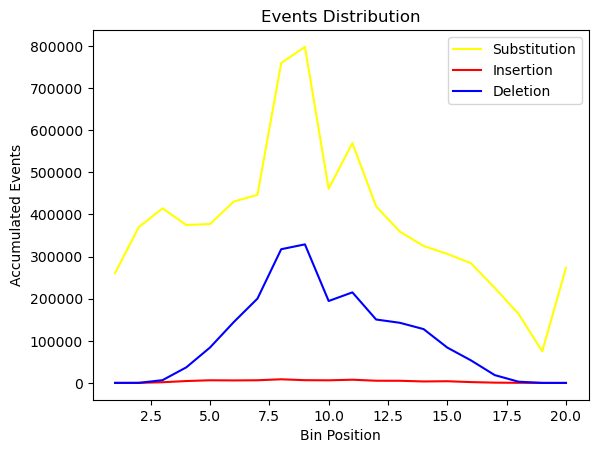

In [15]:
import pysam
import numpy as np
import matplotlib.pyplot as plt

mismatch_bam_path = '/casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edn.bam'
insertion_bam_path = '/casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edn.bam'
deletion_bam_path = '/casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edn.bam'

mismatch_file = pysam.AlignmentFile(mismatch_bam_path, 'rb')
insertion_file = pysam.AlignmentFile(insertion_bam_path, 'rb')
deletion_file = pysam.AlignmentFile(deletion_bam_path, 'rb')

bins_mismatch = np.zeros(20)
bins_insertion = np.zeros(20)
bins_deletion = np.zeros(20)

# Mismatch
for read in mismatch_file.fetch():
    read_length = read.infer_read_length()
    bin_size = read_length / 20
    md_tags = read.get_tag('MD') if read.has_tag('MD') else ''

    if md_tags:
        num = 0
        i = 0
        while i < len(md_tags):
            if md_tags[i].isdigit():
                num = num * 10 + int(md_tags[i])
            elif md_tags[i].isalpha():
                if num != 0:
                    bin_index = min(int(num / bin_size), 19)
                    bins_mismatch[bin_index] += 1
                num = 0
            elif md_tags[i] == '^':
                while i < len(md_tags) - 1 and not md_tags[i + 1].isdigit():
                    i += 1
            i += 1

# Insertion
for read in insertion_file.fetch():
    read_length = read.query_length
    bin_size = read_length / 20
    cigar_tuples = read.cigartuples

    insertion_point = 0

    for cigar_tuple in cigar_tuples:
        cigar_code, cigar_length = cigar_tuple

        if cigar_code == 0:
            insertion_point += cigar_length
        elif cigar_code == 1:
            for i in range(cigar_length):
                bin_idx = min(int((insertion_point + i) / bin_size), 19)
                bins_insertion[bin_idx] += 1
            insertion_point += cigar_length

# Deletion
for read in deletion_file.fetch():
    read_length = read.query_length
    bin_size = read_length / 20
    cigar_tuples = read.cigartuples

    deletion_point = 0

    for cigar_tuple in cigar_tuples:
        cigar_code, cigar_length = cigar_tuple

        if cigar_code == 0:
            deletion_point += cigar_length
        elif cigar_code == 2:
            bin_idx = min(int(deletion_point / bin_size), 19)
            bins_deletion[bin_idx] += 1
            deletion_point += cigar_length

plt.plot(range(1, 21), bins_mismatch, label='Substitution', color='yellow')
plt.plot(range(1, 21), bins_insertion, label='Insertion', color='red')
plt.plot(range(1, 21), bins_deletion, label='Deletion', color='blue')
plt.xlabel('Bin Position')
plt.ylabel('Accumulated Events')
plt.title('Events Distribution')
plt.legend()
plt.show()


In [16]:
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edfilter.bam| awk -F '\t' '$6~"M"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edfilter.bam| awk -F '\t' '$6~"D"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edfilter.bam| awk -F '\t' '$6~"I"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edfilter.bam| awk -F '\t' '$6~"S"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edfilter.bam| awk -F '\t' '$6~"H"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edfilter.bam| awk -F '\t' '$6~"N"{print $0}' | wc -l

9634742
2214959
45320
414982
8114
612538


In [17]:
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edn.bam| awk -F '\t' '$6~"M"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edn.bam| awk -F '\t' '$6~"D"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edn.bam| awk -F '\t' '$6~"I"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edn.bam| awk -F '\t' '$6~"S"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edn.bam| awk -F '\t' '$6~"H"{print $0}' | wc -l
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edn.bam| awk -F '\t' '$6~"N"{print $0}' | wc -l

9022204
2104667
43038
399731
8114
0


In [19]:
!samtools index /casa/minseok/p/practice/bioinfo-final-data/RNA-control.bam

In [20]:
nm_sum_5= calculate_nm_sum('/casa/minseok/p/practice/bioinfo-final-data/RNA-control.bam')
print(nm_sum_5)

5422569


In [21]:
!samtools view /casa/minseok/p/practice/bioinfo-final-data/RNA-control.bam | wc -l

24971058


In [23]:
import pysam
import re

def count_deletions(bam_file):
    bamfile = pysam.AlignmentFile(bam_file, "rb")
    deletion_sum = 0
    deletion_regex = re.compile(r'(\d+)D')

    for read in bamfile:
        cigarstring = read.cigarstring

        if cigarstring is None:
            continue
    
        deletions = deletion_regex.findall(cigarstring)
        deletion_sum += sum(int(d) for d in deletions)

    bamfile.close()

    return deletion_sum


deletion_sum = count_deletions('/casa/minseok/p/practice/bioinfo-final-data/RNA-control.bam')
print(deletion_sum)


320154


In [24]:
deletion_sum_1 = count_deletions('/casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G.bam')
print(deletion_sum_1)

5618076


In [25]:
import pysam
import re

def count_insertions(bam_file):
    bamfile = pysam.AlignmentFile(bam_file, "rb")
    insertion_sum = 0

    insertion_regex = re.compile(r'(\d+)I')

    for read in bamfile:
        cigarstring = read.cigarstring
        
        if cigarstring is None:
            continue

        insertions = insertion_regex.findall(cigarstring)
        insertion_sum += sum(int(i) for i in insertions)

    bamfile.close()

    return insertion_sum

insertion_sum = count_insertions('/casa/minseok/p/practice/bioinfo-final-data/RNA-control.bam')
print(insertion_sum)

#아래 것은 오류 (deletion을 한 번 더 계산함)

475011
5618076


In [27]:
insertion_sum_1 = count_insertions('/casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G.bam')
print(insertion_sum_1)

192408


In [28]:
#FLAG으로 unmapped, (-)strand filter
!samtools view -b -F 20 \
/casa/minseok/p/practice/bioinfo-final-data/RNA-control.bam \
> /casa/minseok/p/practice/bioinfo-final-data/RNA-control-flag.bam

!samtools index /casa/minseok/p/practice/bioinfo-final-data/RNA-control-flag.bam

# edit distance 0인 read는 모두 제거
!samtools view -h /casa/minseok/p/practice/bioinfo-final-data/RNA-control-flag.bam \
| awk -F '\t' '!($0 ~ /\tNM:i:0\t/)' | samtools view -bS - > \
/casa/minseok/p/practice/bioinfo-final-data/RNA-control-edfilter.bam

!samtools index /casa/minseok/p/practice/bioinfo-final-data/RNA-control-edfilter.bam

# N까지 제거 (spliced)
!samtools view -h /casa/minseok/p/practice/bioinfo-final-data/RNA-control-edfilter.bam \
| awk -F '\t' '$6 !~ "N"{print $0}' | samtools view -bS - > \
/casa/minseok/p/practice/bioinfo-final-data/RNA-control-edn.bam

!samtools index /casa/minseok/p/practice/bioinfo-final-data/RNA-control-edn.bam

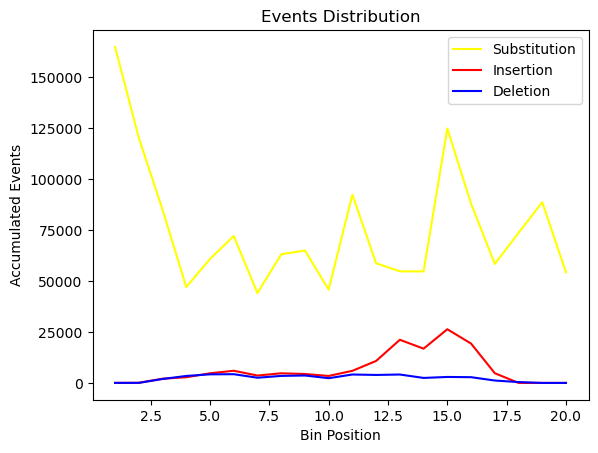

In [29]:
mismatch_bam_path = '/casa/minseok/p/practice/bioinfo-final-data/RNA-control-edn.bam'
insertion_bam_path = '/casa/minseok/p/practice/bioinfo-final-data/RNA-control-edn.bam'
deletion_bam_path = '/casa/minseok/p/practice/bioinfo-final-data/RNA-control-edn.bam'

mismatch_file = pysam.AlignmentFile(mismatch_bam_path, 'rb')
insertion_file = pysam.AlignmentFile(insertion_bam_path, 'rb')
deletion_file = pysam.AlignmentFile(deletion_bam_path, 'rb')

bins_mismatch = np.zeros(20)
bins_insertion = np.zeros(20)
bins_deletion = np.zeros(20)

# Mismatch
for read in mismatch_file.fetch():
    read_length = read.infer_read_length()
    bin_size = read_length / 20
    md_tags = read.get_tag('MD') if read.has_tag('MD') else ''

    if md_tags:
        num = 0
        i = 0
        while i < len(md_tags):
            if md_tags[i].isdigit():
                num = num * 10 + int(md_tags[i])
            elif md_tags[i].isalpha():
                if num != 0:
                    bin_index = min(int(num / bin_size), 19)
                    bins_mismatch[bin_index] += 1
                num = 0
            elif md_tags[i] == '^':
                while i < len(md_tags) - 1 and not md_tags[i + 1].isdigit():
                    i += 1
            i += 1

# Insertion
for read in insertion_file.fetch():
    read_length = read.query_length
    bin_size = read_length / 20
    cigar_tuples = read.cigartuples

    insertion_point = 0

    for cigar_tuple in cigar_tuples:
        cigar_code, cigar_length = cigar_tuple

        if cigar_code == 0:
            insertion_point += cigar_length
        elif cigar_code == 1:
            for i in range(cigar_length):
                bin_idx = min(int((insertion_point + i) / bin_size), 19)
                bins_insertion[bin_idx] += 1
            insertion_point += cigar_length

# Deletion
for read in deletion_file.fetch():
    read_length = read.query_length
    bin_size = read_length / 20
    cigar_tuples = read.cigartuples

    deletion_point = 0

    for cigar_tuple in cigar_tuples:
        cigar_code, cigar_length = cigar_tuple

        if cigar_code == 0:
            deletion_point += cigar_length
        elif cigar_code == 2:
            bin_idx = min(int(deletion_point / bin_size), 19)
            bins_deletion[bin_idx] += 1
            deletion_point += cigar_length

plt.plot(range(1, 21), bins_mismatch, label='Substitution', color='yellow')
plt.plot(range(1, 21), bins_insertion, label='Insertion', color='red')
plt.plot(range(1, 21), bins_deletion, label='Deletion', color='blue')
plt.xlabel('Bin Position')
plt.ylabel('Accumulated Events')
plt.title('Events Distribution')
plt.legend()
plt.show()

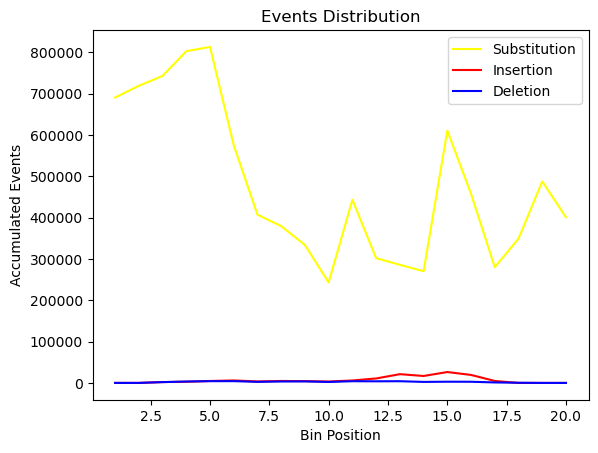

In [36]:
for read in mismatch_file.fetch():
    read_length = read.infer_read_length()
    bin_size = read_length / 20
    md_tags = read.get_tag('MD') if read.has_tag('MD') else ''

    if md_tags:
        num = 0
        i = 0
        while i < len(md_tags):
            if md_tags[i].isdigit():
                num = num * 10 + int(md_tags[i])
            elif md_tags[i].isalpha():
                if num != 0:
                    bin_index = min(int(num / bin_size), 19)
                    bins_mismatch[bin_index] += 1
                num = 0
            elif md_tags[i] == '^':
                while i < len(md_tags) - 1 and not md_tags[i + 1].isdigit():
                    i += 1
            i += 1

        if num != 0:
            bin_index = min(int(num / bin_size), 19)
            bins_mismatch[bin_index] += 1


plt.plot(range(1, 21), bins_mismatch, label='Substitution', color='yellow')
plt.plot(range(1, 21), bins_insertion, label='Insertion', color='red')
plt.plot(range(1, 21), bins_deletion, label='Deletion', color='blue')
plt.xlabel('Bin Position')
plt.ylabel('Accumulated Events')
plt.title('Events Distribution')
plt.legend()
plt.show()

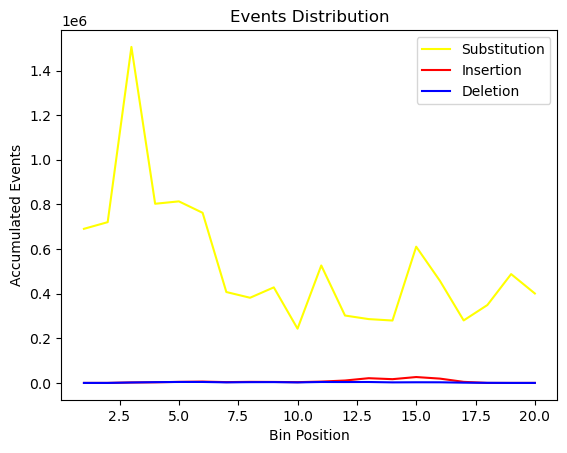

In [37]:
for read in mismatch_file.fetch():
    read_length = read.infer_read_length()
    bin_size = read_length / 20
    md_tags = read.get_tag('MD') if read.has_tag('MD') else ''

    if md_tags:
        num = 0
        mismatch_count = 0
        i = 0
        while i < len(md_tags):
            if md_tags[i].isdigit():
                num = num * 10 + int(md_tags[i])
            elif md_tags[i].isalpha():
                mismatch_count += 1
            elif md_tags[i] == '^':
                while i < len(md_tags) - 1 and not md_tags[i + 1].isdigit():
                    i += 1
            i += 1

        if num != 0 and mismatch_count != 0:
            bin_index = min(int(mismatch_count * bin_size), 19)
            bins_mismatch[bin_index] += 1


plt.plot(range(1, 21), bins_mismatch, label='Substitution', color='yellow')
plt.plot(range(1, 21), bins_insertion, label='Insertion', color='red')
plt.plot(range(1, 21), bins_deletion, label='Deletion', color='blue')
plt.xlabel('Bin Position')
plt.ylabel('Accumulated Events')
plt.title('Events Distribution')
plt.legend()
plt.show()

In [4]:
RNA = bam_to_df('/casa/minseok/p/practice/bioinfo-final-data/RNA-control-edn.bam')
RNA

,query_name,cigarstring,md_tag
0,SRR458753.18727684,27S27M,16T10
1,SRR458753.15996305,39M15S,2A9A26
2,SRR458753.6719205,36M18S,3G27C3T
3,SRR458753.16011281,43M11S,3C3A35
4,SRR458753.16777219,36M1D14M4S,36^A14
...,...,...,...
1201504,SRR458753.13612117,1S40M13S,4C35
1201505,SRR458753.16365158,1S40M13S,4C35
1201506,SRR458753.17716881,1S45M8S,4C40
1201507,SRR458753.3049261,44M10S,3C40


In [42]:
RNA['md_split'] = RNA['md_tag'].str.split('(A|G|T|C)')

RNA['md_split'] = RNA['md_split'].apply(lambda d: d if d is not None else [])

split_RNA = pd.DataFrame(RNA['md_split'].to_list())


In [43]:
split_RNA

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,16,T,10,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2,A,9,A,26,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,3,G,27,C,3,T,,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,3,C,3,A,35,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,36^,A,14,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201504,4,C,35,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1201505,4,C,35,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1201506,4,C,40,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1201507,3,C,40,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [44]:
import re

RNA['md_tag'] = RNA['md_tag'].apply(lambda x: re.sub(r'\^\D+', '', x))

RNA['md_split'] = RNA['md_tag'].str.split('(A|G|T|C)')

split_RNA = pd.DataFrame(RNA['md_split'].to_list())
split_RNA


,0,1,2,3,4,5,6,7,8,9,10
0,16,T,10,None,None,None,None,None,None,None,None
1,2,A,9,A,26,None,None,None,None,None,None
2,3,G,27,C,3,T,,None,None,None,None
3,3,C,3,A,35,None,None,None,None,None,None
4,3614,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
1201504,4,C,35,None,None,None,None,None,None,None,None
1201505,4,C,35,None,None,None,None,None,None,None,None
1201506,4,C,40,None,None,None,None,None,None,None,None
1201507,3,C,40,None,None,None,None,None,None,None,None


In [50]:
RNA['md_tag'] = RNA['md_tag'].apply(lambda x: re.sub(r'\^[^0-9]*(?=\d)', '', x))

RNA['md_split'] = RNA['md_tag'].str.split('(A|G|T|C)')

split_RNA = pd.DataFrame(RNA['md_split'].to_list())
split_RNA

,0,1,2,3,4,5,6,7,8,9,10
0,16,T,10,None,None,None,None,None,None,None,None
1,2,A,9,A,26,None,None,None,None,None,None
2,3,G,27,C,3,T,,None,None,None,None
3,3,C,3,A,35,None,None,None,None,None,None
4,3614,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
1201504,4,C,35,None,None,None,None,None,None,None,None
1201505,4,C,35,None,None,None,None,None,None,None,None
1201506,4,C,40,None,None,None,None,None,None,None,None
1201507,3,C,40,None,None,None,None,None,None,None,None


In [57]:
#deletion 제거
!samtools view -h /casa/minseok/p/practice/bioinfo-final-data/RNA-control-edn.bam \
| awk -F '\t' '!($0 ~ /\^[A-Za-z]+/)' | samtools view -bS - > \
/casa/minseok/p/practice/bioinfo-final-data/RNA-control-dele.bam

!samtools index /casa/minseok/p/practice/bioinfo-final-data/RNA-control-dele.bam



In [58]:
!samtools view /casa/minseok/p/practice/bioinfo-final-data/RNA-control-dele.bam| awk -F '\t' '$6~"D"{print $0}' | wc -l

0


In [6]:
RNA1 = bam_to_df('/casa/minseok/p/practice/bioinfo-final-data/RNA-control-dele.bam')
RNA1

,query_name,cigarstring,md_tag
0,SRR458753.18727684,27S27M,16T10
1,SRR458753.15996305,39M15S,2A9A26
2,SRR458753.6719205,36M18S,3G27C3T
3,SRR458753.16011281,43M11S,3C3A35
4,SRR458753.20287352,50M4S,7T42
...,...,...,...
1153869,SRR458753.13612117,1S40M13S,4C35
1153870,SRR458753.16365158,1S40M13S,4C35
1153871,SRR458753.17716881,1S45M8S,4C40
1153872,SRR458753.3049261,44M10S,3C40


In [60]:
RNA1['md_split'] = RNA1['md_tag'].str.split('(A|G|T|C)')

RNA1['md_split'] = RNA1['md_split'].apply(lambda d: d if d is not None else [])

split_RNA1 = pd.DataFrame(RNA1['md_split'].to_list())
split_RNA1


,0,1,2,3,4,5,6,7,8,9,10
0,16,T,10,None,None,None,None,None,None,None,None
1,2,A,9,A,26,None,None,None,None,None,None
2,3,G,27,C,3,T,,None,None,None,None
3,3,C,3,A,35,None,None,None,None,None,None
4,7,T,42,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
1153869,4,C,35,None,None,None,None,None,None,None,None
1153870,4,C,35,None,None,None,None,None,None,None,None
1153871,4,C,40,None,None,None,None,None,None,None,None
1153872,3,C,40,None,None,None,None,None,None,None,None


In [9]:
def calculate_read_length(row):
    total = 0
    for item in row:
        if isinstance(item, int) or (isinstance(item, str) and item.isdigit()):
            total += int(item)
        elif isinstance(item, str):
            total += 1
    return total

# split_RNA1['read_length'] = split_RNA1.apply(calculate_read_length, axis=1)
# split_RNA1

In [63]:
split_RNA1['bin_size'] = split_RNA1['read_length']/20
split_RNA1

,0,1,2,3,4,5,6,7,8,9,10,read_length,bin_size
0,16,T,10,None,None,None,None,None,None,None,None,27,1.35
1,2,A,9,A,26,None,None,None,None,None,None,39,1.95
2,3,G,27,C,3,T,,None,None,None,None,37,1.85
3,3,C,3,A,35,None,None,None,None,None,None,43,2.15
4,7,T,42,None,None,None,None,None,None,None,None,50,2.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153869,4,C,35,None,None,None,None,None,None,None,None,40,2.00
1153870,4,C,35,None,None,None,None,None,None,None,None,40,2.00
1153871,4,C,40,None,None,None,None,None,None,None,None,45,2.25
1153872,3,C,40,None,None,None,None,None,None,None,None,44,2.20


In [95]:
mismatch_counts = []

for idx, row in split_RNA1.iterrows():
    bins = [0]*20

    for col in range(split_RNA1.columns.get_loc(1), split_RNA1.columns.get_loc('read_length')):
        if isinstance(row[col], str) and row[col].isalpha():
            mismatch_position = sum([int(val) for val in row[:col] if str(val).isdigit()])
            bin_index = min(int(mismatch_position / row['bin_size']), 19)
            bins[bin_index] += 1
    
    mismatch_counts.append(bins)

bins_df = pd.DataFrame(mismatch_counts, columns=[f'bin_{i+1}' for i in range(20)])

split_RNA1 = pd.concat([split_RNA1, bins_df], axis=1)

split_RNA1

,0,1,2,3,4,5,6,7,8,9,...,bin_11,bin_12,bin_13,bin_14,bin_15,bin_16,bin_17,bin_18,bin_19,bin_20
0,16,T,10,None,None,None,None,None,None,None,...,0,1,0,0,0,0,0,0,0,0
1,2,A,9,A,26,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0
2,3,G,27,C,3,T,,None,None,None,...,0,0,0,0,0,0,1,1,0,0
3,3,C,3,A,35,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0
4,7,T,42,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153869,4,C,35,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0
1153870,4,C,35,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0
1153871,4,C,40,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0
1153872,3,C,40,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0


In [8]:
RNA1['md_split'] = RNA1['md_tag'].str.split('(A|G|T|C)')

RNA1['md_split'] = RNA1['md_split'].apply(lambda d: d if d is not None else [])

split_RNA_test = pd.DataFrame(RNA1['md_split'].to_list())
split_RNA_test

,0,1,2,3,4,5,6,7,8,9,10
0,16,T,10,None,None,None,None,None,None,None,None
1,2,A,9,A,26,None,None,None,None,None,None
2,3,G,27,C,3,T,,None,None,None,None
3,3,C,3,A,35,None,None,None,None,None,None
4,7,T,42,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
1153869,4,C,35,None,None,None,None,None,None,None,None
1153870,4,C,35,None,None,None,None,None,None,None,None
1153871,4,C,40,None,None,None,None,None,None,None,None
1153872,3,C,40,None,None,None,None,None,None,None,None


In [10]:
split_RNA_test['read_length'] = split_RNA_test.apply(calculate_read_length, axis=1)
split_RNA_test

,0,1,2,3,4,5,6,7,8,9,10,read_length
0,16,T,10,None,None,None,None,None,None,None,None,27
1,2,A,9,A,26,None,None,None,None,None,None,39
2,3,G,27,C,3,T,,None,None,None,None,37
3,3,C,3,A,35,None,None,None,None,None,None,43
4,7,T,42,None,None,None,None,None,None,None,None,50
...,...,...,...,...,...,...,...,...,...,...,...,...
1153869,4,C,35,None,None,None,None,None,None,None,None,40
1153870,4,C,35,None,None,None,None,None,None,None,None,40
1153871,4,C,40,None,None,None,None,None,None,None,None,45
1153872,3,C,40,None,None,None,None,None,None,None,None,44


In [20]:
import pandas as pd
import numpy as np

def calc_mismatch(row):
    mismatch_positions = []
    position = 0
    for index in range(0, len(row)-1):  
        if pd.isnull(row[index]) or row[index] == '':  
            break
        if isinstance(row[index], int) or row[index].isdigit(): 
            position += int(row[index])
        else: 
            mismatch_positions.append((position+1)/row['read_length'])
            position = 0
    return mismatch_positions

split_RNA_test['mismatch_position_ratio'] = split_RNA_test.apply(calc_mismatch, axis=1)
split_RNA_test



,0,1,2,3,4,5,6,7,8,9,10,read_length,mismatch_position_ratio
0,16,T,10,None,None,None,None,None,None,None,None,27,[0.6296296296296297]
1,2,A,9,A,26,None,None,None,None,None,None,39,"[0.07692307692307693, 0.2564102564102564]"
2,3,G,27,C,3,T,,None,None,None,None,37,"[0.10810810810810811, 0.7567567567567568, 0.10..."
3,3,C,3,A,35,None,None,None,None,None,None,43,"[0.09302325581395349, 0.09302325581395349]"
4,7,T,42,None,None,None,None,None,None,None,None,50,[0.16]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153869,4,C,35,None,None,None,None,None,None,None,None,40,[0.125]
1153870,4,C,35,None,None,None,None,None,None,None,None,40,[0.125]
1153871,4,C,40,None,None,None,None,None,None,None,None,45,[0.1111111111111111]
1153872,3,C,40,None,None,None,None,None,None,None,None,44,[0.09090909090909091]


In [22]:
split_RNA_test.head(30)




,0,1,2,3,4,5,6,7,8,9,10,read_length,mismatch_position_ratio
0,16,T,10,None,None,None,None,None,None,None,None,27,[0.6296296296296297]
1,2,A,9,A,26,None,None,None,None,None,None,39,"[0.07692307692307693, 0.2564102564102564]"
2,3,G,27,C,3,T,,None,None,None,None,37,"[0.10810810810810811, 0.7567567567567568, 0.10..."
3,3,C,3,A,35,None,None,None,None,None,None,43,"[0.09302325581395349, 0.09302325581395349]"
4,7,T,42,None,None,None,None,None,None,None,None,50,[0.16]
5,28,A,1,C,,A,,None,None,None,None,34,"[0.8529411764705882, 0.058823529411764705]"
6,39,A,1,T,1,None,None,None,None,None,None,43,"[0.9302325581395349, 0.046511627906976744]"
7,39,A,1,T,1,None,None,None,None,None,None,43,"[0.9302325581395349, 0.046511627906976744]"
8,39,A,1,T,1,None,None,None,None,None,None,43,"[0.9302325581395349, 0.046511627906976744]"
9,47,T,6,None,None,None,None,None,None,None,None,54,[0.8888888888888888]


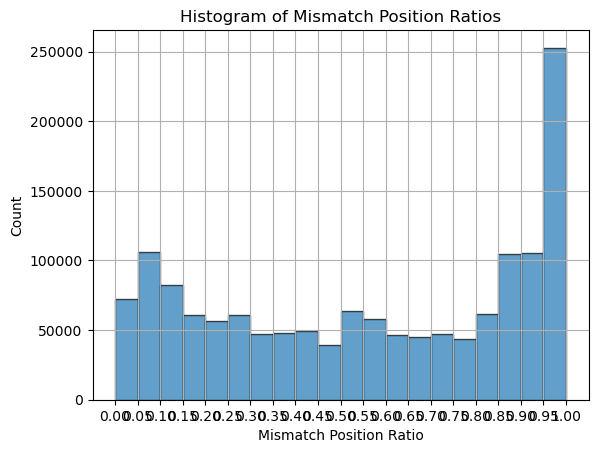

In [23]:
import matplotlib.pyplot as plt

mismatch_position_ratios = [ratio for sublist in split_RNA_test['mismatch_position_ratio'] for ratio in sublist]

bins = np.linspace(0, 1, 21)

plt.hist(mismatch_position_ratios, bins, alpha=0.7, edgecolor='black')
plt.title('Histogram of Mismatch Position Ratios')
plt.xlabel('Mismatch Position Ratio')
plt.ylabel('Count')
plt.xticks(bins)
plt.grid(True)
plt.show()

In [38]:
def get_mismatch_position(md_tag):
    mismatch_position_list = []
    tmp = ''
    current_position = 0
    for ch in md_tag:
        if ch.isdigit():
            tmp += ch
        elif tmp:
            current_position += int(tmp) + 1
            mismatch_position_list.append(current_position)
            tmp = ''
        else:
            current_position += 1
            mismatch_position_list.append(current_position)
    if tmp:
        current_position += int(tmp)
    return mismatch_position_list, current_position



In [43]:
seParseMdTag = RNA1['md_tag'].apply(get_mismatch_position)

In [45]:
RNA1['mismatch_position'] = seParseMdTag.str[0].apply(np.array)
RNA1['length']            = seParseMdTag.str[1].astype(int)
RNA1

,query_name,cigarstring,md_tag,md_split,mismatch_position,length
0,SRR458753.18727684,27S27M,16T10,"[16, T, 10]",[17],27
1,SRR458753.15996305,39M15S,2A9A26,"[2, A, 9, A, 26]","[3, 13]",39
2,SRR458753.6719205,36M18S,3G27C3T,"[3, G, 27, C, 3, T, ]","[4, 32, 36]",36
3,SRR458753.16011281,43M11S,3C3A35,"[3, C, 3, A, 35]","[4, 8]",43
4,SRR458753.20287352,50M4S,7T42,"[7, T, 42]",[8],50
...,...,...,...,...,...,...
1153869,SRR458753.13612117,1S40M13S,4C35,"[4, C, 35]",[5],40
1153870,SRR458753.16365158,1S40M13S,4C35,"[4, C, 35]",[5],40
1153871,SRR458753.17716881,1S45M8S,4C40,"[4, C, 40]",[5],45
1153872,SRR458753.3049261,44M10S,3C40,"[3, C, 40]",[4],44


In [58]:
RNA1['scaled_position'] = (RNA1['mismatch_position'] / RNA1['length'] * 20)
print(RNA1.shape)
RNA1.head(30)

(1153874, 7)


,query_name,cigarstring,md_tag,md_split,mismatch_position,length,scaled_position
0,SRR458753.18727684,27S27M,16T10,"[16, T, 10]",[17],27,[12.592592592592593]
1,SRR458753.15996305,39M15S,2A9A26,"[2, A, 9, A, 26]","[3, 13]",39,"[1.5384615384615385, 6.666666666666666]"
2,SRR458753.6719205,36M18S,3G27C3T,"[3, G, 27, C, 3, T, ]","[4, 32, 36]",36,"[2.2222222222222223, 17.77777777777778, 20.0]"
3,SRR458753.16011281,43M11S,3C3A35,"[3, C, 3, A, 35]","[4, 8]",43,"[1.8604651162790697, 3.7209302325581395]"
4,SRR458753.20287352,50M4S,7T42,"[7, T, 42]",[8],50,[3.2]
5,SRR458753.15979385,32M19S,28A1CA,"[28, A, 1, C, , A, ]","[29, 31, 32]",32,"[18.125, 19.375, 20.0]"
6,SRR458753.992421,43M11S,39A1T1,"[39, A, 1, T, 1]","[40, 42]",43,"[18.6046511627907, 19.53488372093023]"
7,SRR458753.14392314,43M11S,39A1T1,"[39, A, 1, T, 1]","[40, 42]",43,"[18.6046511627907, 19.53488372093023]"
8,SRR458753.18225486,43M11S,39A1T1,"[39, A, 1, T, 1]","[40, 42]",43,"[18.6046511627907, 19.53488372093023]"
9,SRR458753.9137718,54M,47T6,"[47, T, 6]",[48],54,[17.77777777777778]


In [54]:
scaled_positions = np.hstack(RNA1['scaled_position'])
scaled_positions.shape

(1784515,)

(array([ 32513.,  44478.,  36408.,  41754.,  43101.,  41972.,  46907.,
         44739.,  41254.,  46120.,  67000.,  52131.,  58799.,  64830.,
         61361.,  56801.,  65742.,  87366., 216359., 634880.]),
 array([ 0.37037037,  1.35185185,  2.33333333,  3.31481481,  4.2962963 ,
         5.27777778,  6.25925926,  7.24074074,  8.22222222,  9.2037037 ,
        10.18518519, 11.16666667, 12.14814815, 13.12962963, 14.11111111,
        15.09259259, 16.07407407, 17.05555556, 18.03703704, 19.01851852,
        20.        ]),
 <BarContainer object of 20 artists>)

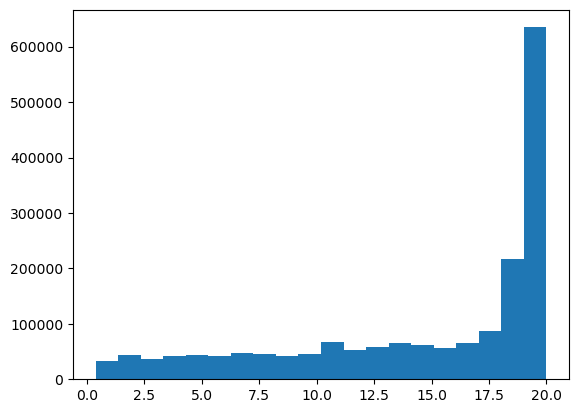

In [55]:
plt.hist(scaled_positions, bins = 20)

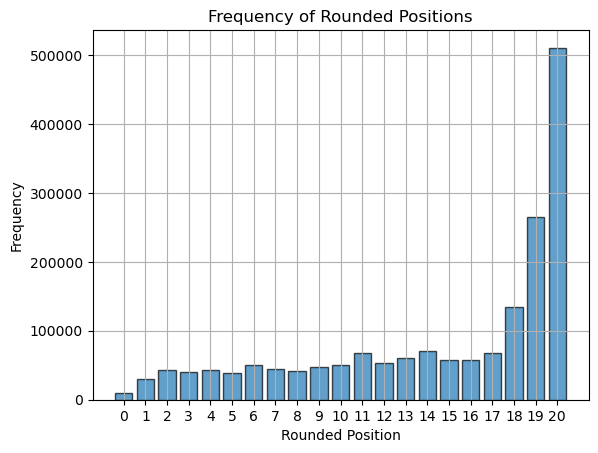

In [56]:
import matplotlib.pyplot as plt

rounded_positions = [round(pos) for sublist in RNA1['scaled_position'] for pos in sublist]

values, counts = np.unique(rounded_positions, return_counts=True)

plt.bar(values, counts, alpha=0.7, edgecolor='black')
plt.title('Frequency of Rounded Positions')
plt.xlabel('Rounded Position')
plt.ylabel('Frequency')
plt.xticks(range(21))
plt.grid(True)
plt.show()


In [62]:

contains_one = RNA1['scaled_position'].apply(lambda x: 20 in x)
num_rows_with_one = contains_one.sum()

print(f"The number of lists containing 20: {num_rows_with_one}")

The number of lists containing 20: 366305


In [66]:
#FLAG으로 unmapped, (-)strand filter
!samtools view -b -F 4 \
/casa/minseok/p/practice/bioinfo-final-data/RNA-control.bam \
> /casa/minseok/p/practice/bioinfo-final-data/RNA-control-mapped.bam

!samtools index /casa/minseok/p/practice/bioinfo-final-data/RNA-control-mapped.bam

In [67]:
# deletion 제거
!samtools view -h /casa/minseok/p/practice/bioinfo-final-data/RNA-control-mapped.bam \
| awk -F '\t' '!($0 ~ /\^[A-Za-z]+/)' | samtools view -bS - > \
/casa/minseok/p/practice/bioinfo-final-data/RNA-control-mapped-dele.bam

!samtools index /casa/minseok/p/practice/bioinfo-final-data/RNA-control-mapped-dele.bam

In [68]:
RNA2 = bam_to_df('/casa/minseok/p/practice/bioinfo-final-data/RNA-control-mapped-dele.bam')
RNA2

,query_name,cigarstring,md_tag
0,SRR458753.752088,1S12M69631N38M,9C1T38
1,SRR458753.1603345,1S12M76828N40M1S,9C1T29T10
2,SRR458753.3943561,1S12M76828N40M1S,9C1T29T10
3,SRR458753.6175517,12M44915N42M,9C1T8A33
4,SRR458753.9349084,1S12M38580N41M,9C1T41
...,...,...,...
12221710,SRR458753.4093352,39M15S,38G
12221711,SRR458753.1484610,37M17S,37
12221712,SRR458753.7310022,36M18S,36
12221713,SRR458753.10551287,32M22S,32


In [85]:
seParseMdTag2 = RNA2['md_tag'].apply(get_mismatch_position)
RNA2['mismatch_position'] = seParseMdTag2.str[0].apply(np.array)
RNA2['length']            = seParseMdTag2.str[1].astype(int)
RNA2

/tmp/ipykernel_16680/3307437499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RNA2['mismatch_position'] = seParseMdTag2.str[0].apply(np.array)
/tmp/ipykernel_16680/3307437499.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RNA2['length']            = seParseMdTag2.str[1].astype(int)


,query_name,cigarstring,md_tag,mismatch_position,length,scaled_position
0,SRR458753.752088,1S12M69631N38M,9C1T38,"[10, 12]",50,[12.592592592592593]
1,SRR458753.1603345,1S12M76828N40M1S,9C1T29T10,"[10, 12, 42]",52,"[1.5384615384615385, 6.666666666666666]"
2,SRR458753.3943561,1S12M76828N40M1S,9C1T29T10,"[10, 12, 42]",52,"[2.2222222222222223, 17.77777777777778, 20.0]"
3,SRR458753.6175517,12M44915N42M,9C1T8A33,"[10, 12, 21]",54,"[1.8604651162790697, 3.7209302325581395]"
4,SRR458753.9349084,1S12M38580N41M,9C1T41,"[10, 12]",53,[3.2]
...,...,...,...,...,...,...
1153869,SRR458753.13719174,36M18S,36,[],36,[2.5]
1153870,SRR458753.13732229,36M18S,36,[],36,[2.5]
1153871,SRR458753.13980450,36M18S,36,[],36,[2.2222222222222223]
1153872,SRR458753.14466486,36M18S,36,[],36,[1.8181818181818183]


In [86]:
RNA2['scaled_position'] = (RNA2['mismatch_position'] / RNA2['length'] * 20)
RNA2 = RNA2.dropna(subset=['scaled_position'])
RNA2

/tmp/ipykernel_16680/1258373001.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RNA2['scaled_position'] = (RNA2['mismatch_position'] / RNA2['length'] * 20)


,query_name,cigarstring,md_tag,mismatch_position,length,scaled_position
0,SRR458753.752088,1S12M69631N38M,9C1T38,"[10, 12]",50,"[4.0, 4.8]"
1,SRR458753.1603345,1S12M76828N40M1S,9C1T29T10,"[10, 12, 42]",52,"[3.8461538461538463, 4.615384615384616, 16.153..."
2,SRR458753.3943561,1S12M76828N40M1S,9C1T29T10,"[10, 12, 42]",52,"[3.8461538461538463, 4.615384615384616, 16.153..."
3,SRR458753.6175517,12M44915N42M,9C1T8A33,"[10, 12, 21]",54,"[3.7037037037037033, 4.444444444444445, 7.7777..."
4,SRR458753.9349084,1S12M38580N41M,9C1T41,"[10, 12]",53,"[3.7735849056603774, 4.528301886792453]"
...,...,...,...,...,...,...
1153869,SRR458753.13719174,36M18S,36,[],36,[]
1153870,SRR458753.13732229,36M18S,36,[],36,[]
1153871,SRR458753.13980450,36M18S,36,[],36,[]
1153872,SRR458753.14466486,36M18S,36,[],36,[]


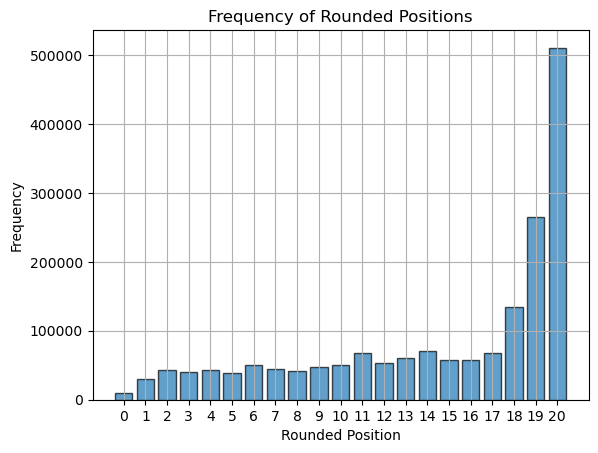

In [87]:
import matplotlib.pyplot as plt

rounded_positions = [round(pos) for sublist in RNA1['scaled_position'] for pos in sublist]
values, counts = np.unique(rounded_positions, return_counts=True)

plt.bar(values, counts, alpha=0.7, edgecolor='black')
plt.title('Frequency of Rounded Positions')
plt.xlabel('Rounded Position')
plt.ylabel('Frequency')
plt.xticks(range(21))
plt.grid(True)
plt.show()


In [88]:
RNA3 = bam_to_df('/casa/minseok/p/practice/bioinfo-final-data/RNA-control-mapped.bam')
RNA3

,query_name,cigarstring,md_tag
0,SRR458753.752088,1S12M69631N38M,9C1T38
1,SRR458753.1603345,1S12M76828N40M1S,9C1T29T10
2,SRR458753.3943561,1S12M76828N40M1S,9C1T29T10
3,SRR458753.6175517,12M44915N42M,9C1T8A33
4,SRR458753.9349084,1S12M38580N41M,9C1T41
...,...,...,...
12376819,SRR458753.4093352,39M15S,38G
12376820,SRR458753.1484610,37M17S,37
12376821,SRR458753.7310022,36M18S,36
12376822,SRR458753.10551287,32M22S,32


In [89]:
seParseMdTag3 = RNA3['md_tag'].apply(get_mismatch_position)
RNA3['mismatch_position'] = seParseMdTag3.str[0].apply(np.array)
RNA3['length']            = seParseMdTag3.str[1].astype(int)
RNA3

,query_name,cigarstring,md_tag,mismatch_position,length
0,SRR458753.752088,1S12M69631N38M,9C1T38,"[10, 12]",50
1,SRR458753.1603345,1S12M76828N40M1S,9C1T29T10,"[10, 12, 42]",52
2,SRR458753.3943561,1S12M76828N40M1S,9C1T29T10,"[10, 12, 42]",52
3,SRR458753.6175517,12M44915N42M,9C1T8A33,"[10, 12, 21]",54
4,SRR458753.9349084,1S12M38580N41M,9C1T41,"[10, 12]",53
...,...,...,...,...,...
12376819,SRR458753.4093352,39M15S,38G,[39],39
12376820,SRR458753.1484610,37M17S,37,[],37
12376821,SRR458753.7310022,36M18S,36,[],36
12376822,SRR458753.10551287,32M22S,32,[],32


In [90]:
RNA3['scaled_position'] = (RNA3['mismatch_position'] / RNA3['length'] * 20)
RNA3 = RNA3.dropna(subset=['scaled_position'])
RNA3

,query_name,cigarstring,md_tag,mismatch_position,length,scaled_position
0,SRR458753.752088,1S12M69631N38M,9C1T38,"[10, 12]",50,"[4.0, 4.8]"
1,SRR458753.1603345,1S12M76828N40M1S,9C1T29T10,"[10, 12, 42]",52,"[3.8461538461538463, 4.615384615384616, 16.153..."
2,SRR458753.3943561,1S12M76828N40M1S,9C1T29T10,"[10, 12, 42]",52,"[3.8461538461538463, 4.615384615384616, 16.153..."
3,SRR458753.6175517,12M44915N42M,9C1T8A33,"[10, 12, 21]",54,"[3.7037037037037033, 4.444444444444445, 7.7777..."
4,SRR458753.9349084,1S12M38580N41M,9C1T41,"[10, 12]",53,"[3.7735849056603774, 4.528301886792453]"
...,...,...,...,...,...,...
12376819,SRR458753.4093352,39M15S,38G,[39],39,[20.0]
12376820,SRR458753.1484610,37M17S,37,[],37,[]
12376821,SRR458753.7310022,36M18S,36,[],36,[]
12376822,SRR458753.10551287,32M22S,32,[],32,[]


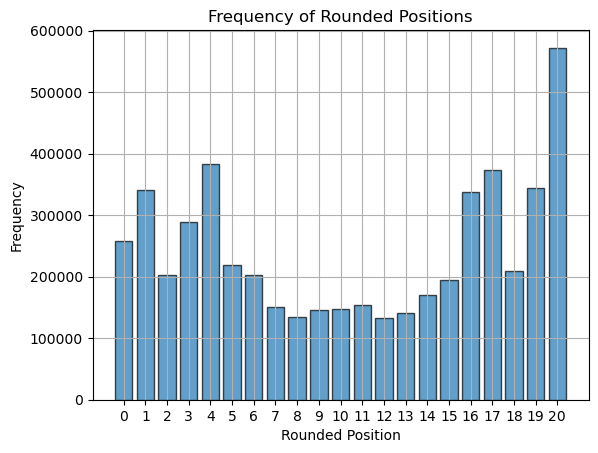

In [91]:
import matplotlib.pyplot as plt

rounded_positions = [round(pos) for sublist in RNA3['scaled_position'] for pos in sublist]
values, counts = np.unique(rounded_positions, return_counts=True)

plt.bar(values, counts, alpha=0.7, edgecolor='black')
plt.title('Frequency of Rounded Positions')
plt.xlabel('Rounded Position')
plt.ylabel('Frequency')
plt.xticks(range(21))
plt.grid(True)
plt.show()

In [92]:
RNA3.head(30)

,query_name,cigarstring,md_tag,mismatch_position,length,scaled_position
0,SRR458753.752088,1S12M69631N38M,9C1T38,"[10, 12]",50,"[4.0, 4.8]"
1,SRR458753.1603345,1S12M76828N40M1S,9C1T29T10,"[10, 12, 42]",52,"[3.8461538461538463, 4.615384615384616, 16.153..."
2,SRR458753.3943561,1S12M76828N40M1S,9C1T29T10,"[10, 12, 42]",52,"[3.8461538461538463, 4.615384615384616, 16.153..."
3,SRR458753.6175517,12M44915N42M,9C1T8A33,"[10, 12, 21]",54,"[3.7037037037037033, 4.444444444444445, 7.7777..."
4,SRR458753.9349084,1S12M38580N41M,9C1T41,"[10, 12]",53,"[3.7735849056603774, 4.528301886792453]"
5,SRR458753.14277566,12M44915N42M,9C1T42,"[10, 12]",54,"[3.7037037037037033, 4.444444444444445]"
6,SRR458753.15151078,20S31M,11T19,[12],31,[7.741935483870968]
7,SRR458753.1236691,33M75602N2M1I11M4S,46,[],46,[]
8,SRR458753.18252725,42M12S,42,[],42,[]
9,SRR458753.18727684,27S27M,16T10,[17],27,[12.592592592592593]


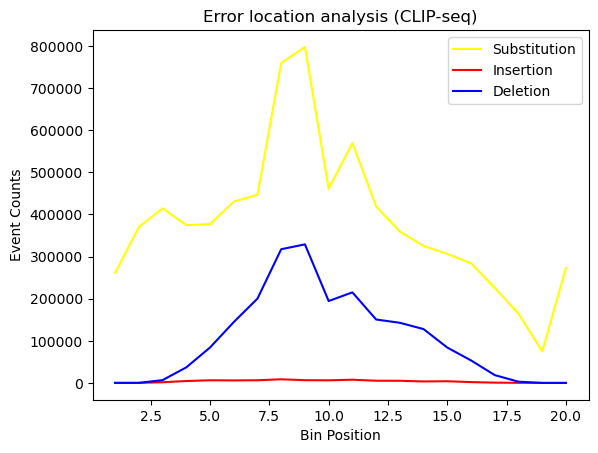

In [93]:
import pysam
import numpy as np
import matplotlib.pyplot as plt

mismatch_bam_path = '/casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edn.bam'
insertion_bam_path = '/casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edn.bam'
deletion_bam_path = '/casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-edn.bam'

mismatch_file = pysam.AlignmentFile(mismatch_bam_path, 'rb')
insertion_file = pysam.AlignmentFile(insertion_bam_path, 'rb')
deletion_file = pysam.AlignmentFile(deletion_bam_path, 'rb')

bins_mismatch = np.zeros(20)
bins_insertion = np.zeros(20)
bins_deletion = np.zeros(20)

# Mismatch
for read in mismatch_file.fetch():
    read_length = read.infer_read_length()
    bin_size = read_length / 20
    md_tags = read.get_tag('MD') if read.has_tag('MD') else ''

    if md_tags:
        num = 0
        i = 0
        while i < len(md_tags):
            if md_tags[i].isdigit():
                num = num * 10 + int(md_tags[i])
            elif md_tags[i].isalpha():
                if num != 0:
                    bin_index = min(int(num / bin_size), 19)
                    bins_mismatch[bin_index] += 1
                num = 0
            elif md_tags[i] == '^':
                while i < len(md_tags) - 1 and not md_tags[i + 1].isdigit():
                    i += 1
            i += 1

# Insertion
for read in insertion_file.fetch():
    read_length = read.query_length
    bin_size = read_length / 20
    cigar_tuples = read.cigartuples

    insertion_point = 0

    for cigar_tuple in cigar_tuples:
        cigar_code, cigar_length = cigar_tuple

        if cigar_code == 0:
            insertion_point += cigar_length
        elif cigar_code == 1:
            for i in range(cigar_length):
                bin_idx = min(int((insertion_point + i) / bin_size), 19)
                bins_insertion[bin_idx] += 1
            insertion_point += cigar_length

# Deletion
for read in deletion_file.fetch():
    read_length = read.query_length
    bin_size = read_length / 20
    cigar_tuples = read.cigartuples

    deletion_point = 0

    for cigar_tuple in cigar_tuples:
        cigar_code, cigar_length = cigar_tuple

        if cigar_code == 0:
            deletion_point += cigar_length
        elif cigar_code == 2:
            bin_idx = min(int(deletion_point / bin_size), 19)
            bins_deletion[bin_idx] += 1
            deletion_point += cigar_length

plt.plot(range(1, 21), bins_mismatch, label='Substitution', color=(1.0, 1.0, 0.0, 1.0))
plt.plot(range(1, 21), bins_insertion, label='Insertion', color='red')
plt.plot(range(1, 21), bins_deletion, label='Deletion', color='blue')
plt.xlabel('Bin Position')
plt.ylabel('Event Counts')
plt.title('Error location analysis (CLIP-seq)')
plt.legend()
plt.show()

In [94]:
#FLAG으로 unmapped filter
!samtools view -b -F 4 \
/casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G.bam \
> /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-mapped.bam

!samtools index /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-mapped.bam

#FLAG filter 전후 확인
!samtools view /casa/minseok/p/practice/bioinfo-final-data/CLIP-35L33G-mapped.bam | wc -l

36589778


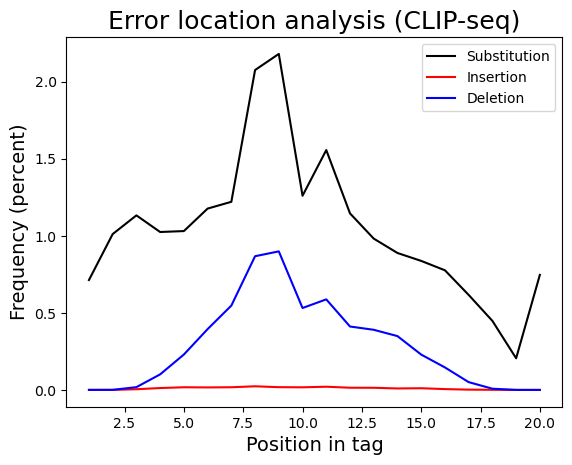

In [103]:
bins_mismatch_percent = [value / 365897.78 for value in bins_mismatch]
bins_insertion_percent = [value / 365897.78 for value in bins_insertion]
bins_deletion_percent = [value / 365897.78 for value in bins_deletion]

plt.plot(range(1, 21), bins_mismatch_percent, label='Substitution', color='black')
plt.plot(range(1, 21), bins_insertion_percent, label='Insertion', color='red')
plt.plot(range(1, 21), bins_deletion_percent, label='Deletion', color='blue')
plt.xlabel('Position in tag', fontsize=14)
plt.ylabel('Frequency (percent)', fontsize=14)
plt.title('Error location analysis (CLIP-seq)', fontsize=18)
plt.legend()
plt.show()


In [105]:
#FLAG으로 unmapped filter
!samtools view -b -F 4 \
/casa/minseok/p/practice/bioinfo-final-data/RNA-control.bam \
> /casa/minseok/p/practice/bioinfo-final-data/RNA-control-mapped.bam

!samtools index /casa/minseok/p/practice/bioinfo-final-data/RNA-control-mapped.bam

#FLAG filter 전후 확인
!samtools view /casa/minseok/p/practice/bioinfo-final-data/RNA-control-mapped.bam | wc -l


12376824


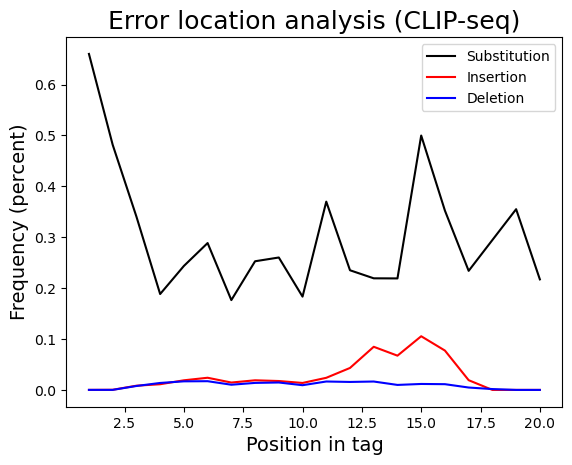

In [107]:
mismatch_bam_path = '/casa/minseok/p/practice/bioinfo-final-data/RNA-control-edn.bam'
insertion_bam_path = '/casa/minseok/p/practice/bioinfo-final-data/RNA-control-edn.bam'
deletion_bam_path = '/casa/minseok/p/practice/bioinfo-final-data/RNA-control-edn.bam'

mismatch_file = pysam.AlignmentFile(mismatch_bam_path, 'rb')
insertion_file = pysam.AlignmentFile(insertion_bam_path, 'rb')
deletion_file = pysam.AlignmentFile(deletion_bam_path, 'rb')

bins_mismatch = np.zeros(20)
bins_insertion = np.zeros(20)
bins_deletion = np.zeros(20)

# Mismatch
for read in mismatch_file.fetch():
    read_length = read.infer_read_length()
    bin_size = read_length / 20
    md_tags = read.get_tag('MD') if read.has_tag('MD') else ''

    if md_tags:
        num = 0
        i = 0
        while i < len(md_tags):
            if md_tags[i].isdigit():
                num = num * 10 + int(md_tags[i])
            elif md_tags[i].isalpha():
                if num != 0:
                    bin_index = min(int(num / bin_size), 19)
                    bins_mismatch[bin_index] += 1
                num = 0
            elif md_tags[i] == '^':
                while i < len(md_tags) - 1 and not md_tags[i + 1].isdigit():
                    i += 1
            i += 1

# Insertion
for read in insertion_file.fetch():
    read_length = read.query_length
    bin_size = read_length / 20
    cigar_tuples = read.cigartuples

    insertion_point = 0

    for cigar_tuple in cigar_tuples:
        cigar_code, cigar_length = cigar_tuple

        if cigar_code == 0:
            insertion_point += cigar_length
        elif cigar_code == 1:
            for i in range(cigar_length):
                bin_idx = min(int((insertion_point + i) / bin_size), 19)
                bins_insertion[bin_idx] += 1
            insertion_point += cigar_length

# Deletion
for read in deletion_file.fetch():
    read_length = read.query_length
    bin_size = read_length / 20
    cigar_tuples = read.cigartuples

    deletion_point = 0

    for cigar_tuple in cigar_tuples:
        cigar_code, cigar_length = cigar_tuple

        if cigar_code == 0:
            deletion_point += cigar_length
        elif cigar_code == 2:
            bin_idx = min(int(deletion_point / bin_size), 19)
            bins_deletion[bin_idx] += 1
            deletion_point += cigar_length

bins_mismatch_percent = [value / 249710.58 for value in bins_mismatch]
bins_insertion_percent = [value / 249710.58 for value in bins_insertion]
bins_deletion_percent = [value / 249710.58 for value in bins_deletion]

plt.plot(range(1, 21), bins_mismatch_percent, label='Substitution', color='black')
plt.plot(range(1, 21), bins_insertion_percent, label='Insertion', color='red')
plt.plot(range(1, 21), bins_deletion_percent, label='Deletion', color='blue')
plt.xlabel('Position in tag', fontsize=14)
plt.ylabel('Frequency (percent)', fontsize=14)
plt.title('Error location analysis (RNA-seq)', fontsize=18)
plt.legend()
plt.show()


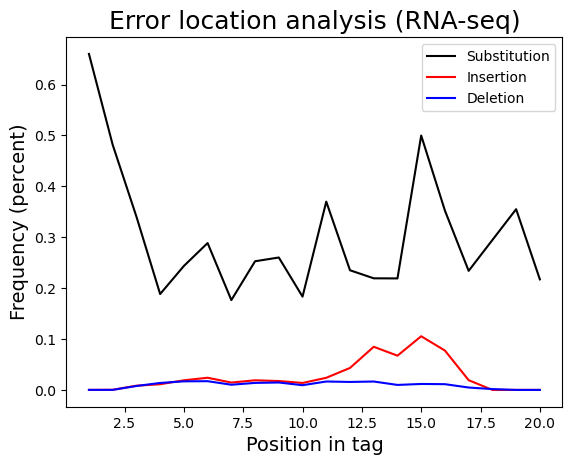

In [108]:
bins_mismatch_percent = [value / 249710.58 for value in bins_mismatch]
bins_insertion_percent = [value / 249710.58 for value in bins_insertion]
bins_deletion_percent = [value / 249710.58 for value in bins_deletion]

plt.plot(range(1, 21), bins_mismatch_percent, label='Substitution', color='black')
plt.plot(range(1, 21), bins_insertion_percent, label='Insertion', color='red')
plt.plot(range(1, 21), bins_deletion_percent, label='Deletion', color='blue')
plt.xlabel('Position in tag', fontsize=14)
plt.ylabel('Frequency (percent)', fontsize=14)
plt.title('Error location analysis (RNA-seq)', fontsize=18)
plt.legend()
plt.show()

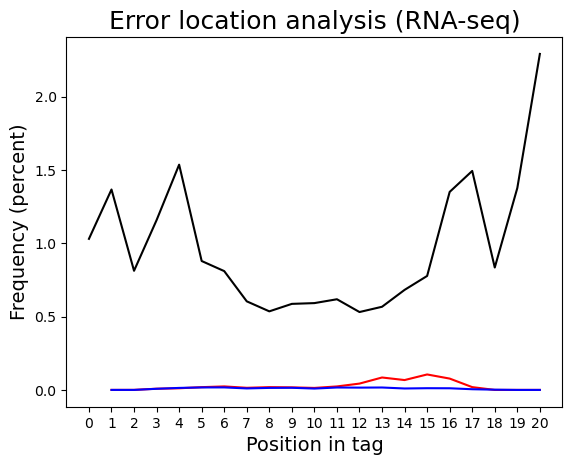

In [116]:
frequency_counts = [value / 249710.58 for value in counts]

plt.plot(values, frequency_counts, color='black', alpha=1)
plt.plot(range(1, 21), bins_insertion_percent, label='Insertion', color='red')
plt.plot(range(1, 21), bins_deletion_percent, label='Deletion', color='blue')
plt.xlabel('Position in tag', fontsize=14)
plt.ylabel('Frequency (percent)', fontsize=14)
plt.title('Error location analysis (RNA-seq)', fontsize=18)
plt.xticks(range(21))
plt.show()

